## Introduction to our first task: 'Plant-Seedlings'

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pydot
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras import optimizers
from keras import backend as K
from keras.applications.resnet50 import preprocess_input
from keras.callbacks import ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [3]:
#adam = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
lrs=0.08
sgd = optimizers.SGD(lr=lrs, momentum=0.9)

In [3]:
PATH = "../data/plant-seedlings/"
sz=224
batch_size=64
loss_fn="categorical_crossentropy"
num_classes=12

In [4]:
train_data_dir = f'{PATH}train'
validation_data_dir = f'{PATH}valid'

In [6]:
os.listdir(PATH)

['models',
 'train',
 'test.zip',
 'train.zip',
 'sample_submission.csv',
 'test',
 'valid',
 'all',
 'tmp',
 'sample_submission.csv.zip']

In [7]:
files = os.listdir(f'{PATH}valid/Black-grass')[:5]
files

['b9dfffe2a.png',
 '84e43f2ff.png',
 'f20bf670a.png',
 '5db29d0b5.png',
 'c3b38d028.png']

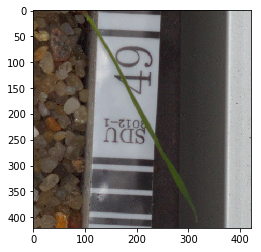

In [8]:
img = plt.imread(f'{PATH}valid/Black-grass/{files[0]}')
plt.imshow(img);

In [9]:
img.shape

(421, 421, 3)

In [10]:
img[:4,:4]

array([[[0.3254902 , 0.2627451 , 0.19215687],
        [0.33333334, 0.2627451 , 0.19607843],
        [0.32156864, 0.24705882, 0.18039216],
        [0.2901961 , 0.21568628, 0.14117648]],

       [[0.3254902 , 0.25490198, 0.1882353 ],
        [0.3254902 , 0.25490198, 0.1882353 ],
        [0.32156864, 0.24313726, 0.1764706 ],
        [0.3137255 , 0.23921569, 0.17254902]],

       [[0.31764707, 0.24705882, 0.18039216],
        [0.31764707, 0.24313726, 0.1764706 ],
        [0.31764707, 0.23921569, 0.17254902],
        [0.3137255 , 0.23529412, 0.17254902]],

       [[0.30588236, 0.23529412, 0.16470589],
        [0.29803923, 0.22745098, 0.16078432],
        [0.30980393, 0.23921569, 0.17254902],
        [0.30588236, 0.23137255, 0.16470589]]], dtype=float32)

In [5]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        rescale=1./255,
        shear_range=0.2,
        fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir, 
    shuffle=False,
    target_size=(sz, sz),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    shuffle=False,
    target_size=(sz, sz),
    batch_size=batch_size,
    class_mode='categorical')

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(sz,sz,3))
base_model.summary()

/home/surajit_dey_airbus/anaconda3/envs/condaenv/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [7]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [8]:
#removes the last layer of a nn and adds a fully-connected layer for predicting num_classes
#model.layers.pop()
#for layer in base_model.layers: layer.trainable = False
#last = base_model.layers[-1].output
#x = Flatten()(last)
#predictions = Dense(num_classes, activation='softmax', name='fc_start')(x)

In [8]:
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers: layer.trainable = False
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [22]:
counter = 0
for layer in base_model.layers:
    print(layer.name, layer.trainable)
    counter += 1

input_1 False
conv1_pad False
conv1 False
bn_conv1 False
activation_1 False
pool1_pad False
max_pooling2d_1 False
res2a_branch2a False
bn2a_branch2a False
activation_2 False
res2a_branch2b False
bn2a_branch2b False
activation_3 False
res2a_branch2c False
res2a_branch1 False
bn2a_branch2c False
bn2a_branch1 False
add_1 False
activation_4 False
res2b_branch2a False
bn2b_branch2a False
activation_5 False
res2b_branch2b False
bn2b_branch2b False
activation_6 False
res2b_branch2c False
bn2b_branch2c False
add_2 False
activation_7 False
res2c_branch2a False
bn2c_branch2a False
activation_8 False
res2c_branch2b False
bn2c_branch2b False
activation_9 False
res2c_branch2c False
bn2c_branch2c False
add_3 False
activation_10 False
res3a_branch2a False
bn3a_branch2a False
activation_11 False
res3a_branch2b False
bn3a_branch2b False
activation_12 False
res3a_branch2c False
res3a_branch1 False
bn3a_branch2c False
bn3a_branch1 False
add_4 False
activation_13 False
res3b_branch2a False
bn3b_branch2a F

In [23]:
print("#Layers = ", counter)

#Layers =  175


In [29]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1 False
bn_conv1 False
activation_1 False
pool1_pad False
max_pooling2d_1 False
res2a_branch2a False
bn2a_branch2a False
activation_2 False
res2a_branch2b False
bn2a_branch2b False
activation_3 False
res2a_branch2c False
res2a_branch1 False
bn2a_branch2c False
bn2a_branch1 False
add_1 False
activation_4 False
res2b_branch2a False
bn2b_branch2a False
activation_5 False
res2b_branch2b False
bn2b_branch2b False
activation_6 False
res2b_branch2c False
bn2b_branch2c False
add_2 False
activation_7 False
res2c_branch2a False
bn2c_branch2a False
activation_8 False
res2c_branch2b False
bn2c_branch2b False
activation_9 False
res2c_branch2c False
bn2c_branch2c False
add_3 False
activation_10 False
res3a_branch2a False
bn3a_branch2a False
activation_11 False
res3a_branch2b False
bn3a_branch2b False
activation_12 False
res3a_branch2c False
res3a_branch1 False
bn3a_branch2c False
bn3a_branch1 False
add_4 False
activation_13 False
res3b_branch2a False
bn3b_branch2a F

In [9]:
model.compile(optimizer='rmsprop', loss=loss_fn, metrics=['accuracy'])

In [16]:
plot_model(model, to_file='model.png')

In [14]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [10]:
%%time
model.fit_generator(train_generator, train_generator.n // batch_size, epochs=20, workers=4,
        validation_data=validation_generator, validation_steps=validation_generator.n // batch_size, callbacks=[])

Epoch 1/20
59/59 [==============================] - 75s 1s/step - loss: 15.2608 - acc: 0.0397 - val_loss: 14.0771 - val_acc: 0.0580
Epoch 2/20
10/59 [====>.........................] - ETA: 1:04 - loss: 10.8042 - acc: 0.3297

KeyboardInterrupt: 

In [23]:
split_at = 140
for layer in model.layers[:split_at]: layer.trainable = False
for layer in model.layers[split_at:]: layer.trainable = True
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])    

In [24]:
%%time
model.fit_generator(train_generator, train_generator.n // batch_size, epochs=1, workers=3,
        validation_data=validation_generator, validation_steps=validation_generator.n // batch_size)

Epoch 1/1
359/359 [==============================] - 108s 300ms/step - loss: 0.0777 - acc: 0.9753 - val_loss: 0.8917 - val_acc: 0.9380
CPU times: user 5min 30s, sys: 15.7 s, total: 5min 46s
Wall time: 1min 48s
